In [0]:
import tensorflow as tf
import numpy as np
import pandas as pd

from pandas_datareader import data
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [0]:
# Define the stocks to download. These are top 50 stocks on the S&P 500
tickers =[
          'MSFT',
          'AAPL',
          'AMZN',
          'FB',
          'COF',
          'GOOGL',
          'JNJ',
          'JPM',
          'V',
          'PG',
          'MA',
          'INTC',
          'UNH',
          'BAC',
          'T',
          'HD',
          'XOM',
          'DIS',
          'VZ',
          'KO',
          'MRK',
          'CMCSA',
          'CVX',
          'PEP',
          'AFL',
          'ATVI',
          'AMD',
          'BLK',
          'CCL',
          'CMG',
          'COP',
          'DAL',
          'EBAY',
          'GS',
          'HPQ',
          'IBM',
          'LLY',
          'MCD',
          'MU',
          'MS',
          'NFLX',
          'NKE',
          'NVDA',
          'SBUX',
          'TWTR',
          'VRTX',
          'ACN',
          'WFC',
          'MMM',
          'SLB']

In [0]:
start_date = '2014-01-01'
end_date = '2017-12-29'

# User pandas_reader.data.DataReader to load the desired data.
panel_data = data.DataReader(tickers, 'yahoo', start_date, end_date)
df = panel_data['Close']

#from google.colab import files
#df.to_excel('df.xlsx')
#files.download('df.xlsx')

In [0]:
df.head()

Symbols,MSFT,AAPL,AMZN,FB,COF,GOOGL,JNJ,JPM,V,PG,MA,INTC,UNH,BAC,T,HD,XOM,DIS,VZ,KO,MRK,CMCSA,CVX,PEP,AFL,ATVI,AMD,BLK,CCL,CMG,COP,DAL,EBAY,GS,HPQ,IBM,LLY,MCD,MU,MS,NFLX,NKE,NVDA,SBUX,TWTR,VRTX,ACN,WFC,MMM,SLB
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,37.160000,79.018570,397.970001,54.709999,77.250000,557.117126,91.029999,58.209999,55.252499,80.540001,83.414001,25.790001,74.570000,16.10,34.950001,82.019997,99.750000,76.269997,49.000000,40.660000,49.490002,25.725000,124.139999,82.099998,32.980000,18.070000,3.95,312.799988,39.810001,523.429993,69.779999,27.700001,22.702021,176.889999,12.561308,185.529999,50.730000,96.410004,21.660000,31.030001,51.831429,39.119999,15.860000,38.584999,67.500000,73.830002,81.129997,45.020000,138.130005,88.820000
2014-01-03,36.910000,77.282860,396.440002,54.560001,77.339996,553.053040,91.849998,58.660000,55.290001,80.449997,83.081001,25.780001,75.099998,16.41,34.799999,81.889999,99.510002,76.110001,48.419998,40.459999,49.730000,25.535000,124.349998,82.239998,33.075001,18.290001,4.00,314.170013,39.849998,531.309998,69.959999,29.230000,22.415825,178.149994,12.870118,186.639999,51.099998,96.540001,20.969999,31.510000,51.871429,39.014999,15.670000,38.474998,69.000000,73.449997,81.400002,45.340000,138.449997,88.349998
2014-01-06,36.130001,77.704285,393.630005,57.200001,76.589996,559.219238,92.330002,59.000000,54.957500,80.639999,82.668999,25.459999,74.239998,16.66,34.959999,81.099998,99.660004,75.820000,48.689999,40.270000,49.740002,25.510000,124.019997,82.279999,32.439999,18.080000,4.13,314.070007,39.230000,527.320007,70.260002,29.290001,21.792929,179.369995,12.847411,186.000000,51.529999,95.849998,20.670000,31.620001,51.367142,38.715000,15.880000,38.084999,66.290001,75.500000,80.540001,45.419998,137.630005,88.019997
2014-01-07,36.410000,77.148575,398.029999,57.919998,77.279999,570.000000,94.290001,58.320000,55.377499,81.419998,83.709000,25.590000,76.510002,16.50,34.950001,81.500000,101.070000,76.339996,49.299999,40.389999,50.110001,26.415001,125.070000,83.480003,32.544998,18.320000,4.18,316.959991,39.490002,533.059998,70.370003,28.780001,22.251684,178.289993,12.797457,189.710007,51.189999,96.379997,21.730000,31.520000,48.500000,38.744999,16.139999,38.605000,61.459999,74.489998,81.519997,45.400002,137.649994,87.510002
2014-01-08,35.759998,77.637146,401.920013,58.230000,77.849998,571.186157,94.160004,58.869999,55.555000,80.239998,83.683998,25.430000,75.620003,16.58,34.240002,81.930000,100.739998,75.220001,48.500000,39.939999,49.790001,26.375000,123.290001,83.239998,32.314999,18.340000,4.18,316.859985,39.400002,535.849976,69.690002,29.799999,22.041246,178.440002,12.465940,187.970001,51.110001,95.410004,23.870001,31.559999,48.712856,38.544998,16.360001,39.014999,59.290001,75.230003,82.150002,45.919998,136.630005,86.980003


In [0]:
#df.mean()

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('stock%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('stock%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('stock%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
#Normalize each series Sj(t) by Yj(t) = Sj(t) / avSj(t)
df = df/df.mean()

In [0]:
reframed = series_to_supervised(df, 4, 2)

In [0]:
#keep stock 1 at t+1 to use for predictions
reframed.drop(reframed.iloc[:, 251:], inplace = True, axis = 1)
reframed.head()


,stock1(t-4),stock2(t-4),stock3(t-4),stock4(t-4),stock5(t-4),stock6(t-4),stock7(t-4),stock8(t-4),stock9(t-4),stock10(t-4),stock11(t-4),stock12(t-4),stock13(t-4),stock14(t-4),stock15(t-4),stock16(t-4),stock17(t-4),stock18(t-4),stock19(t-4),stock20(t-4),stock21(t-4),stock22(t-4),stock23(t-4),stock24(t-4),stock25(t-4),stock26(t-4),stock27(t-4),stock28(t-4),stock29(t-4),stock30(t-4),stock31(t-4),stock32(t-4),stock33(t-4),stock34(t-4),stock35(t-4),stock36(t-4),stock37(t-4),stock38(t-4),stock39(t-4),stock40(t-4),...,stock12(t),stock13(t),stock14(t),stock15(t),stock16(t),stock17(t),stock18(t),stock19(t),stock20(t),stock21(t),stock22(t),stock23(t),stock24(t),stock25(t),stock26(t),stock27(t),stock28(t),stock29(t),stock30(t),stock31(t),stock32(t),stock33(t),stock34(t),stock35(t),stock36(t),stock37(t),stock38(t),stock39(t),stock40(t),stock41(t),stock42(t),stock43(t),stock44(t),stock45(t),stock46(t),stock47(t),stock48(t),stock49(t),stock50(t),stock1(t+1)
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-08,0.687066,0.676347,0.642666,0.507804,0.978663,0.771034,0.820334,0.832918,0.732449,0.961929,0.848196,0.772079,0.572188,0.881585,0.955869,0.673897,1.145892,0.770200,1.002955,0.956884,0.847652,0.815898,1.159672,0.816590,0.980884,0.507867,0.668511,0.868979,0.799053,1.012725,1.253524,0.626701,0.822291,0.920221,0.816908,1.149070,0.678656,0.828554,0.886038,0.859012,...,0.761302,0.580245,0.907868,0.936450,0.673157,1.157264,0.759597,0.992721,0.939939,0.852791,0.836514,1.151732,0.827929,0.961106,0.515455,0.707437,0.880258,0.790824,1.036755,1.251907,0.674213,0.798357,0.928285,0.810706,1.164182,0.683739,0.819960,0.976442,0.873684,0.467772,0.743054,0.266602,0.761792,2.040349,0.702627,0.780772,0.878628,0.812304,1.058227,0.656929
2014-01-09,0.682444,0.661490,0.640195,0.506412,0.979803,0.765409,0.827724,0.839357,0.732946,0.960854,0.844810,0.771780,0.576255,0.898560,0.951766,0.672829,1.143135,0.768584,0.991083,0.952177,0.851763,0.809872,1.161634,0.817983,0.983710,0.514050,0.676974,0.872785,0.799856,1.027972,1.256757,0.661317,0.811925,0.926776,0.836991,1.155945,0.683605,0.829671,0.857813,0.872300,...,0.757709,0.583775,0.921557,0.917306,0.670200,1.146007,0.756365,0.972252,0.934997,0.848166,0.838575,1.151732,0.824050,0.955752,0.514331,0.692206,0.878091,0.802064,1.046778,1.247775,0.702720,0.793784,0.922874,0.815432,1.160528,0.691365,0.820390,0.950671,0.873407,0.462367,0.743054,0.256662,0.757594,1.963263,0.712808,0.788375,0.883221,0.811233,1.052144,0.666358
2014-01-10,0.668022,0.665097,0.635657,0.530916,0.970302,0.773943,0.832049,0.844222,0.728539,0.963124,0.840621,0.762200,0.569656,0.912249,0.956142,0.666338,1.144858,0.765656,0.996610,0.947706,0.851934,0.809079,1.158551,0.818380,0.964824,0.508148,0.698975,0.872507,0.787412,1.020252,1.262147,0.662674,0.789363,0.933123,0.835515,1.151981,0.689358,0.823741,0.845541,0.875345,...,0.764295,0.573186,0.918272,0.919494,0.673815,1.154737,0.761314,0.977369,0.944411,0.854332,0.849042,1.130433,0.830515,0.969136,0.510958,0.705745,0.874924,0.827956,1.042018,1.237177,0.711996,0.795156,0.928025,0.818090,1.159785,0.694709,0.823312,0.969897,0.866486,0.455631,0.741415,0.256336,0.758277,1.961543,0.730460,0.790751,0.879011,0.809628,1.072705,0.646759
2014-01-13,0.673199,0.660341,0.642763,0.537599,0.979043,0.788863,0.849712,0.834492,0.734106,0.972440,0.851196,0.766092,0.587074,0.903488,0.955869,0.669624,1.161055,0.770907,1.009096,0.950530,0.858271,0.837782,1.168360,0.830316,0.967947,0.514893,0.707437,0.880536,0.792630,1.031357,1.264123,0.651136,0.805979,0.927504,0.832266,1.174959,0.684809,0.828296,0.888902,0.872577,...,0.763397,0.567354,0.899655,0.910742,0.665270,1.132107,0.739905,0.962632,0.930291,0.909826,0.827157,1.113992,0.819276,0.953224,0.502246,0.698975,0.851394,0.831369,1.025050,1.216877,0.699552,0.800948,0.914967,0.830494,1.140585,0.696582,0.814975,0.954352,0.854583,0.462038,0.724644,0.250306,0.733382,1.989762,0.719532,0.770412,0.871740,0.800710,1.064067,0.661551
2014-01-14,0.6611

In [0]:
#Randomly Split the cases with proportions (90%,10%)
x = reframed.iloc[:,0:250]
y = reframed.iloc[:,-1] 
train, test, ytrain, ytest = train_test_split(x ,y , test_size =0.10, random_state=100)

# PCA

In [0]:
#4.1 Compute a plausible dimension h for H (H=3)
pca=PCA()
pca=pca.fit(train)
eigenvalues = pca.explained_variance_
j=list(range(250))
plt.plot(eigenvalues, marker='o', markerfacecolor='blue', markersize=10, color='skyblue', linewidth=2)
plt.xlabel('k')
plt.ylabel('Eigenvalue')

#to compute small plausible value of H
cumsum=np.cumsum(pca.explained_variance_ratio_)
#print(cumsum)
num_components=np.argmax(cumsum>.90)+1 #account for 0th element
print(num_components)

NameError: ignored

# Autoencoder

In [0]:
train = train.values
test = test.values

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import Constant

# constructing the autoencoder

# determine h through PCA on your own data
# try to find suitable initializers for your own data
h = 3
model = Sequential()
model.add(Dense(h, activation='relu', input_dim=250, bias_initializer=Constant(value=8),name='hidden'))
model.add(Dense(250, activation='relu', bias_initializer=Constant(value=2)))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 3)                 753       
_________________________________________________________________
dense (Dense)                (None, 250)               1000      
Total params: 1,753
Trainable params: 1,753
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras import optimizers, losses

model.compile(optimizer=optimizers.SGD(learning_rate=0.05, decay=1e-7), loss='mean_squared_error')


In [0]:
from tensorflow.keras import callbacks

# the following callback to record losses after each batch
class MyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(train,train,verbose = 0))
      self.MSEtest.append(self.model.evaluate(test,test,verbose = 0))

MyMonitor = MyHistory()

# Keras built-in early-stopping callback
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

In [0]:
Monitor = model.fit(train, train, epochs=20, batch_size=32, callbacks = [MyMonitor, es], validation_data = (test, test), verbose = 2)

# After training, access MSE(AutoTrain) and MSE(AutoTest) through MyMonitor.MSEtrain and MyMonitor.MSEtest.

Epoch 1/20
29/29 - 2s - loss: 0.2799 - val_loss: 0.2591
Epoch 2/20
29/29 - 2s - loss: 0.0701 - val_loss: 0.0632
Epoch 3/20
29/29 - 2s - loss: 0.0541 - val_loss: 0.0517
Epoch 4/20
29/29 - 2s - loss: 0.0478 - val_loss: 0.0497
Epoch 5/20
29/29 - 2s - loss: 0.0521 - val_loss: 0.0486
Epoch 6/20
29/29 - 2s - loss: 0.0493 - val_loss: 0.0476
Epoch 7/20
29/29 - 2s - loss: 0.0426 - val_loss: 0.0465
Epoch 8/20
29/29 - 2s - loss: 0.0440 - val_loss: 0.0461
Epoch 9/20
29/29 - 2s - loss: 0.0452 - val_loss: 0.0455
Epoch 10/20
29/29 - 2s - loss: 0.0516 - val_loss: 0.0457
Epoch 11/20
29/29 - 2s - loss: 0.0525 - val_loss: 0.0458
Epoch 12/20
29/29 - 2s - loss: 0.0556 - val_loss: 0.0457
Epoch 13/20
29/29 - 2s - loss: 0.0455 - val_loss: 0.0450
Epoch 14/20
29/29 - 2s - loss: 0.0476 - val_loss: 0.0446
Epoch 15/20
29/29 - 2s - loss: 0.0462 - val_loss: 0.0443
Epoch 16/20
29/29 - 2s - loss: 0.0417 - val_loss: 0.0442
Epoch 17/20
29/29 - 2s - loss: 0.0500 - val_loss: 0.0445
Epoch 18/20
29/29 - 2s - loss: 0.0453 - 

In [0]:
len(MyMonitor.MSEtrain)

580

In [0]:
model.evaluate(test, test)

4/4 [==============================] - 0s 2ms/step - loss: 0.0430


0.0429578498005867

Text(0.5, 1.0, 'MSE(AutoTrain) & MSE(AutoTest)')

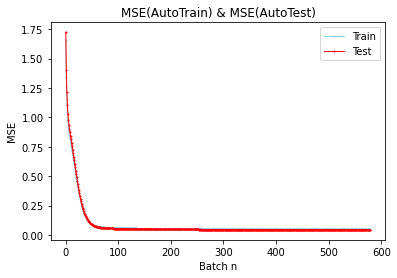

In [0]:
plt.plot(MyMonitor.MSEtrain, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=1, label = "Train")
plt.plot(MyMonitor.MSEtest, marker='o', markerfacecolor='blue', markersize=1, color='red', linewidth=1, label = "Test")
plt.legend( loc = 'upper right')
plt.xlabel('Batch n')
plt.ylabel('MSE')
plt.title('MSE(AutoTrain) & MSE(AutoTest)')

#  4.4 Compute Compressed Inputs 

In [0]:
# extract the hidden layer
Htrain = model.layers[0](train).numpy()
print(len(Htrain))
Htest = model.layers[0](test).numpy()
print(len(Htest))

901
101


In [0]:
# make sure Z is a two-dimensional numpy array
# shape (900,) is different from shape (900,1)
ytrain = ytrain.to_numpy()
ytest = ytest.to_numpy()

ytrain = np.reshape(ytrain,(901,1))
ytest = np.reshape(ytest,(101,1))

In [0]:
price_train = ytrain*54.085025
price_test = ytest*54.085025

In [0]:
#901 cases in NewTrain

#numwth = h*k+k+k+1 =< 901

# for my data h = 3, so k=180

# MLP

In [0]:
mlp = Sequential()
mlp.add(Dense(180, activation='relu', input_dim=h, bias_initializer=Constant(value=5)))
mlp.add(Dense(1, activation='relu', bias_initializer=Constant(value=45))) #choose initializer similar to targer variable values

mlp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 180)               720       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 181       
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [0]:
# configure suitable lr and decay
mlp.compile(optimizer=optimizers.SGD(learning_rate=0.0001, decay=1e-6), loss='mean_squared_error')

In [0]:
class mlpMyHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
      self.MSEtrain = []
      self.MSEtest = []
    def on_batch_end(self, batch, logs={}):
      self.MSEtrain.append(self.model.evaluate(Htrain,price_train,verbose = 0))
      self.MSEtest.append(self.model.evaluate(Htest,price_test,verbose = 0))

mlpMyMonitor = mlpMyHistory()

#es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=90, restore_best_weights=True)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=12, restore_best_weights=True)

In [0]:
mlpMonitor = mlp.fit(Htrain, price_train, epochs=250, batch_size=32, callbacks = [mlpMyMonitor, es], validation_data = (Htest, price_test), verbose = 2)

Epoch 1/250
29/29 - 2s - loss: 142.2701 - val_loss: 274.3903
Epoch 2/250
29/29 - 2s - loss: 118.5979 - val_loss: 118.2357
Epoch 3/250
29/29 - 2s - loss: 102.8875 - val_loss: 115.5418
Epoch 4/250
29/29 - 2s - loss: 91.0163 - val_loss: 99.4351
Epoch 5/250
29/29 - 2s - loss: 100.0126 - val_loss: 91.6679
Epoch 6/250
29/29 - 2s - loss: 91.7977 - val_loss: 92.0052
Epoch 7/250
29/29 - 2s - loss: 66.1078 - val_loss: 78.7660
Epoch 8/250
29/29 - 2s - loss: 60.9192 - val_loss: 66.3646
Epoch 9/250
29/29 - 2s - loss: 84.9887 - val_loss: 148.2042
Epoch 10/250
29/29 - 2s - loss: 45.2878 - val_loss: 69.8483
Epoch 11/250
29/29 - 2s - loss: 54.6608 - val_loss: 70.5625
Epoch 12/250
29/29 - 2s - loss: 58.7738 - val_loss: 68.4370
Epoch 13/250
29/29 - 2s - loss: 29.8423 - val_loss: 38.2992
Epoch 14/250
29/29 - 2s - loss: 30.5055 - val_loss: 26.2947
Epoch 15/250
29/29 - 2s - loss: 19.7632 - val_loss: 29.5471
Epoch 16/250
29/29 - 2s - loss: 17.6739 - val_loss: 19.4134
Epoch 17/250
29/29 - 2s - loss: 16.0999 -

In [0]:
len(mlpMyMonitor.MSEtrain)

2233

Text(0.5, 1.0, 'MSE(NewTrain) & MSE(NewTest)')

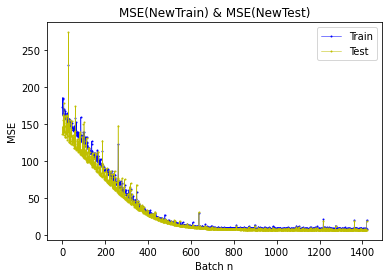

In [0]:
plt.plot(mlpMyMonitor.MSEtrain, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=.5, label = "Train")
plt.plot(mlpMyMonitor.MSEtest, marker='o', markerfacecolor='blue', markersize=1, color='y', linewidth=.5, label= 'Test')
plt.legend()
plt.xlabel('Batch n')
plt.ylabel('MSE')
plt.title('MSE(NewTrain) & MSE(NewTest)')

# Predict Stock Price

In [0]:
#inputsss = np.concatenate((Htrain,Htest), axis=0)

In [0]:
Zt_train = mlp.predict(Htrain)
Zt_test = mlp.predict(Htest)

In [0]:
#true_price = np.concatenate((price_train,price_test), axis=0)

Text(0, 0.5, 'Price')

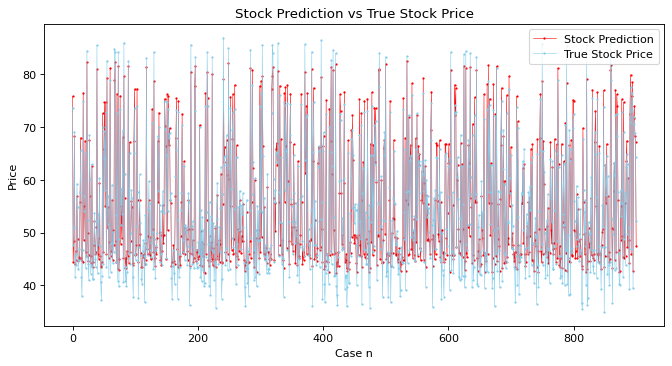

In [0]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Zt_train, marker='o', markerfacecolor='blue', markersize=1, color='red', linewidth=.5,label='Stock Prediction')
plt.plot(price_train, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=.5,label='True Stock Price')
plt.legend()
plt.title('Stock Prediction vs True Stock Price')
plt.xlabel('Case n')
plt.ylabel('Price')


Text(0, 0.5, 'Price')

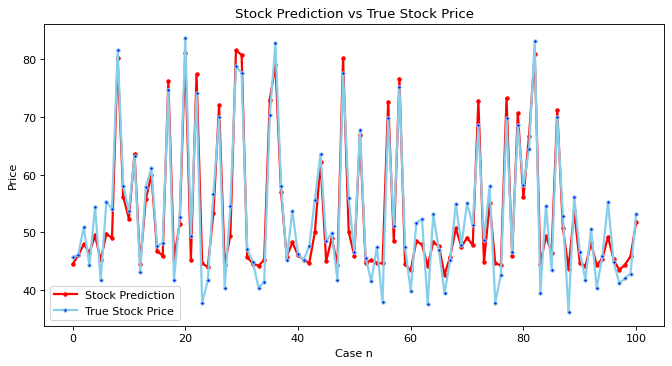

In [0]:
plt.figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Zt_test, marker='o', markerfacecolor='red', markersize=3, color='red', linewidth=2, label = 'Stock Prediction')
plt.plot(price_test, marker='o', markerfacecolor='blue', markersize=3, color='skyblue', linewidth=2, label= 'True Stock Price')
plt.legend()
plt.title('Stock Prediction vs True Stock Price')
plt.xlabel('Case n')
plt.ylabel('Price')

In [0]:
MREP_train = np.mean(abs(Zt_train-price_train)/price_train)
print(MREP_train)
MREP_test = np.mean(abs(Zt_test-price_test)/price_test)
print(MREP_test)

0.05211934925602007
0.056754853599840956
